# Bayesian Baseball Monkeys

The MARCEL baseball projection model, developed by Tom Tango, is a deliberately simple forecasting system for Major League Baseball (MLB) player performance. Named humorously after Marcel the Monkey, it aims to represent the "minimum level of competence" that should be expected from any forecaster. 

> Actually, it is the most basic forecasting system you can have, that uses as little intelligence as possible. So, that's the allusion to the monkey. It uses 3 years of MLB data, with the most recent data weighted heavier. It regresses towards the mean. And it has an age factor. -- *Tom Tango*

Yet, this minimalist approach makes it a transparent, reliable starting point for player projections without requiring extensive computational resources or complex algorithms.

![monkey](assets/Marcel-the-Monkey.png)

### Key Features of the MARCEL Model

1. **Data Utilization**:
   - The model uses three years of MLB data, with the most recent year weighted more heavily. This approach ensures that the projections are based on a player's recent performance while still considering their historical data.

2. **Regression to the Mean**:
   - MARCEL incorporates a regression towards the mean, which helps to temper extreme performances and provide more balanced projections.

3. **Age Factor**:
   - The model includes an age factor to account for the natural aging process of players, which can affect their performance.


Here is the recipe for the model, taken from his website describing the 2004 version of the model:

> 1 - Weight each season as 5/4/3. 2003 counts as "5" and 2001 counts as "3".
> 
> 2 - Determine each player's league average. I removed all pitchers' hitting totals from the league average. I lumped in AL and NL together. I weighted the player's league average using the 5/4/3 process and that's player's PA for that season. I then forced in that player's league average to come in at a total of 1200 PA for each player (2 weights x 600 PA). This is the regression towards the mean component.
> 
> 3 - Add the above two.
> 
> 4 - Determine the projected PA = 0.5 * 2004PA + 0.1 * 2003PA + 200. I take the result of #3, and > prorate it to this projected PA.
> 
> 5 - Determine an age adjustment. Age = 2004 - yearofbirth. If over 29, AgeAdj = (age - 29) * .003. > If under 29, AgeAdj = (age - 29) * .006. Apply this age adjustment to the result of #4.
> 
> 6 - Rebaseline the results against an assumed league average of 2003.

This description relates speficically to batter data, but the methodology can be applied to any annual player statistics.


## A Bayesian Marcel?

An interesting exercise is to consider how we might implement an analog of MARCEL using Bayesian methods. By incorporating a Bayesian framework, we can introduce uncertainty estimates into the projections, which can be valuable for decision-making and risk assessment. 

In the spirit of MARCEL, the goal here is not to have a sophisticated model for making accurate projections, but rather to have a simple, general purpose model that can be used to project arbitrary metrics, usually intended to provide baseline one-year-ahead projections. The only difference is that we will now have probabilistic uncertainty estimates around the resulting projections.

To this end, the three core components have been adapted as follows:

1. The data weights for previous seasons are estimated from the data.
2. A triangular aging function, whose midpoint is estimated from the data.
3. A hierarchical random effect for mean regression when data are sparse.

## Model description

For pitcher $i$ having observed values of some quantity of interest in three consecutive years $y_i^{(t)}, y_i^{(t-1)}, y_i^{(t-2)}$ we are predicting $y_i^{(t+1)}$ via:

$$\theta_i^{(t+1)} = \mu_i + w_0 (\theta_i^{(t)}) + w_1 (\theta_i^{(t-1)}) + w_2 (\theta_i^{(t-2)}) + \beta_{28} a_i^{(t+1)}$$

where $\{w_0, w_1, w_2\}\sim \text{Dirichlet}(\phi)$ are constrained to be ordered and the $\theta_i$ are partially pooled observations to regress extreme values. For Gaussian data, the likelihood is:

$$y_i^{(t)} \sim N(\theta_i^{(t)}, \sigma)$$

For other types of data, this likelihood may be binomial or Poisson.

The coefficient $\beta_{28}$ is a simple triangular aging model that is piecewise linear with a switch point at 28 years of age.

All inputs are automatically standardized to aid in convergence.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az
from pybaseball import batting_stats
import matplotlib.pyplot as plt
import pytensor.tensor as pt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data Preparation

We will use the `pybaseball` package to obtain the data for the model. The package provides a convenient interface to the Statcast data, which contains detailed player statistics for each season. 

In [2]:
data = batting_stats(2020, 2024, qual=1)

hard_hit_subset = data[["Name", "Season", "Team", "Age", "HardHit", "Events"]].copy().reset_index(drop=True)
hard_hit_subset.shape

(3543, 6)

In [3]:
batter_idx, batters = hard_hit_subset['Name'].factorize()
hard_hit_subset["batter_idx"] = batter_idx

In [4]:
age_idx, ages = hard_hit_subset['Age'].factorize(sort=True)
hard_hit_subset["age_idx"] = age_idx

In [5]:
season_idx, seasons = hard_hit_subset['Season'].factorize(sort=True)
hard_hit_subset["season_idx"] = season_idx

So, we will be using years 2020 to 2022 to fit to 2023 outcomes, where the values are observed hard hits. The sample size will be the number of batted balls (`Events`) in each year. 

For convenience, we are using players who have complete data over all 4 seasons.

<Axes: >

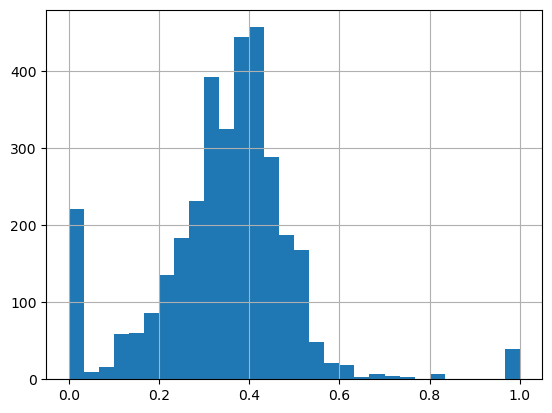

In [7]:
data["HardHit%"].hist(bins=30)

In [8]:
data["HardHit%"].mean(), data["HardHit%"].std()

(0.3471969563944981, 0.15295431850867344)

In [22]:
hard_hit_by_season = hard_hit_subset.pivot_table(index=['Name', 'batter_idx'], values=["Events", "HardHit", "Age"], columns=['Season']).dropna(subset=[('HardHit', 2020), ('HardHit', 2021),
('HardHit', 2022),
('HardHit', 2023)]).reset_index()

hard_hit_by_season

Name batter_idx   Age                         Events  \
Season                              2020  2021  2022  2023  2024   2020   
0          A.J. Pollock        118  32.0  33.0  34.0  35.0   NaN  153.0   
1           Aaron Hicks        400  30.0  31.0  32.0  33.0  34.0  131.0   
2           Aaron Judge          0  28.0  29.0  30.0  31.0  32.0   70.0   
3       Abraham Almonte        838  31.0  32.0  33.0  34.0   NaN    7.0   
4          Abraham Toro        390  23.0  24.0  25.0  26.0  27.0   64.0   
..                  ...        ...   ...   ...   ...   ...   ...    ...   
327      Yordan Alvarez         18  23.0  24.0  25.0  26.0  27.0    7.0   
328            Yu Chang        446  24.0  25.0  26.0  27.0   NaN    7.0   
329        Yuli Gurriel        113  36.0  37.0  38.0  39.0   NaN  189.0   
330      Zach McKinstry        402  25.0  26.0  27.0  28.0  29.0    4.0   
331        Zack Collins        701  25.0  26.0  27.0  28.0   NaN   11.0   

                                   HardHit                              
Season   2021   2022   2023   2024    2020   2021   2022   2023   2024  
0       306.0  395.0  103.0    NaN    66.0  144.0  166.0   42.0    NaN  
1        80.0  278.0  201.0   34.0    50.0   31.0   92.0   59.0   12.0  
2       397.0  404.0  240.0  215.0    29.0  230.0  246.0  154.0  135.0  
3       111.0   23.0    7.0    NaN     1.0   46.0    7.0    5.0    NaN  
4       283.0  263.0   13.0  225.0    18.0   95.0   78.0    4.0   65.0  
..        ...    ...    ...    ...     ...    ...    ...    ...    ...  
327     395.0  371.0  322.0  263.0     5.0  214.0  222.0  168.0  124.0  
328     169.0  111.0   73.0    NaN     1.0   57.0   41.0   28.0    NaN  
329     474.0  475.0  258.0    NaN    67.0  196.0  168.0   89.0    NaN  
330     111.0  116.0  356.0   92.0     2.0   39.0   35.0  118.0   30.0  
331     127.0   57.0    2.0    NaN     6.0   56.0   23.0    2.0    NaN  

[332 rows x 17 columns]

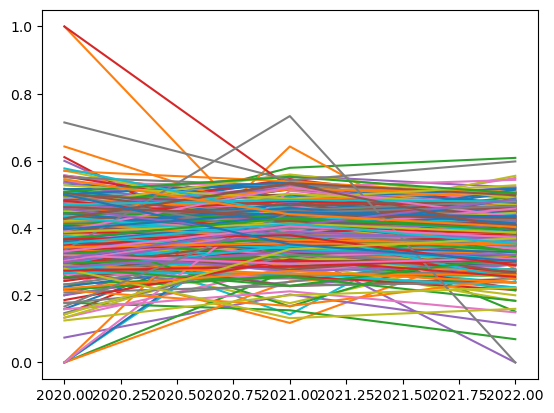

In [32]:
hard_hit_x = (hard_hit_by_season['HardHit'] / hard_hit_by_season['Events'])[[2020, 2021, 2022]]
plt.plot(hard_hit_x.T);

In [11]:
# def get_marcel_data(x, predict_set=False):
#     seasons = np.sort(x.Season.unique())
#     pivoted_data =  x.pivot(index="batter_idx", columns="Season", values=["age_idx", "Events", "HardHit"]).reset_index()
#     if not predict_set:
#         pivoted_data = pivoted_data.dropna()
#     batter_idx = pivoted_data.index.to_numpy()
#     events_y = pivoted_data["Events"][seasons[-1]].to_numpy()
#     hard_hit_y = pivoted_data["HardHit"][seasons[-1]].to_numpy()
#     age_x = pivoted_data["age_idx"][seasons[:3]].to_numpy()
#     events_x = pivoted_data["Events"][seasons[:3]].to_numpy()
#     hard_hit_x = pivoted_data["HardHit"][seasons[:3]].to_numpy()
#     if predict_set:
#         mask = ~np.isnan(events_x).any(1) & ~np.isnan(hard_hit_x).any(1)
#         events_x = events_x[mask]
#         hard_hit_x = hard_hit_x[mask]
#         age_x = age_x[mask]
#         batter_idx = batter_idx[mask]
#         events_y = np.ones(sum(mask)) * np.nan
#         hard_hit_y = np.ones(sum(mask)) * np.nan

#     return batter_idx, age_x, events_x, events_y, hard_hit_x, hard_hit_y

# # batter_idx, age_x, events_x, events_y, hard_hit_x, hard_hit_y = get_marcel_data(hard_hit_subset.query("(Season >= @year) & (Season <= @year + 3)").copy())

# data_chunks = []
# for year in range(2014, 2022):
#     subset = hard_hit_subset.query("(Season >= @year) & (Season <= @year + 3)").copy()
#     data_chunks.append(get_marcel_data(subset, predict_set=(year==2021)))

# batter_idx = np.concatenate([chunk[0] for chunk in data_chunks]).astype(np.int32)
# age_x = np.concatenate([chunk[1] for chunk in data_chunks]).astype(np.int32)
# events_x = np.concatenate([chunk[2] for chunk in data_chunks]).astype(np.int32)
# events_y = np.concatenate([chunk[3] for chunk in data_chunks]).astype(np.float32)
# hard_hit_x = np.concatenate([chunk[4] for chunk in data_chunks]).astype(np.int32)
# hard_hit_y = np.concatenate([chunk[5] for chunk in data_chunks]).astype(np.float32)

    

In [71]:
hard_hit_by_season["Events"][fit_seasons].astype(np.float32).dtypes

Season
2020    float32
2021    float32
2022    float32
dtype: object

In [82]:
coords = {
    'obs': np.arange(len(hard_hit_by_season)), 
    'season': np.arange(3),
}

fit_seasons = [2020, 2021, 2022]

with pm.Model(coords=coords) as marcel:

    age_x = pm.Data("age_x", hard_hit_by_season["Age"][fit_seasons].to_numpy().astype(np.float32))
    events_x = pm.Data("events_x", hard_hit_by_season["Events"][fit_seasons].to_numpy().astype(np.int32))
    hard_hit_x = pm.Data("hard_hit_x", hard_hit_by_season["HardHit"][fit_seasons].to_numpy().astype(np.int32))
    events_y = pm.Data("events_y", hard_hit_by_season["Events"][2023].to_numpy().astype(np.int32))
    hard_hit_y = pm.Data("hard_hit_y", hard_hit_by_season["HardHit"][2023].to_numpy().astype(np.int32))

    # Coefficient for triangular aging
    beta = pm.Normal("beta")
    # Estimate of peak age
    peak_age = pm.Uniform("peak_age", data.Age.min(), data.Age.max())

    # Empirical rates, regressed to mean with beta-binomial
    mu_p = pm.Beta("mu_p", 1, 1)
    sigma_p = pm.Uniform("sigma_p", 0, 1)
    p = pm.Beta("p", mu=mu_p, sigma=sigma_p, dims=("obs", "season"))
    pm.Binomial("rate_like", n=events_x, p=p, observed=hard_hit_x)

    # Marcel weights
    w = pm.Dirichlet(
        "w",
        a=np.array([3, 4, 5])
    )

    # Sum of weighted & regressed years and aging factor
    expected_rate = pm.Deterministic(
        "expected_rate",
        pm.math.invlogit(pm.math.dot(pm.math.logit(p) + beta * (peak_age - age_x), w)),
        dims="obs"
    )

    # # Likelihood of observed hard hits
    pm.Binomial("prediction", n=events_y, p=expected_rate, observed=hard_hit_y)

    

In [83]:
with marcel:
    trace = pm.sample(nuts_sampler="numpyro", target_accept=0.9)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

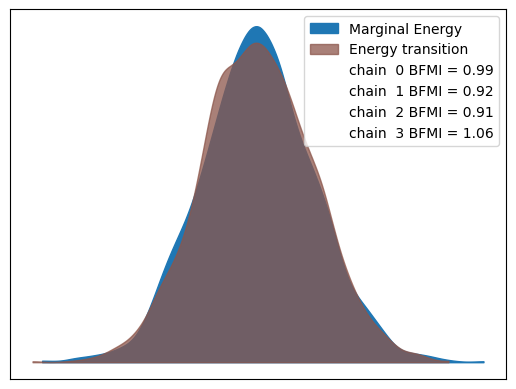

In [84]:
az.plot_energy(trace);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

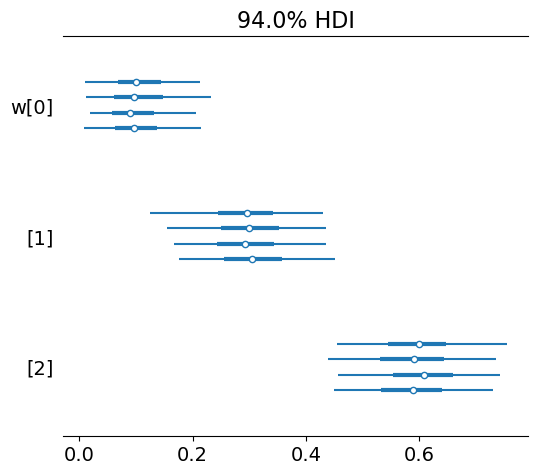

In [38]:
az.plot_forest(trace, var_names='w')

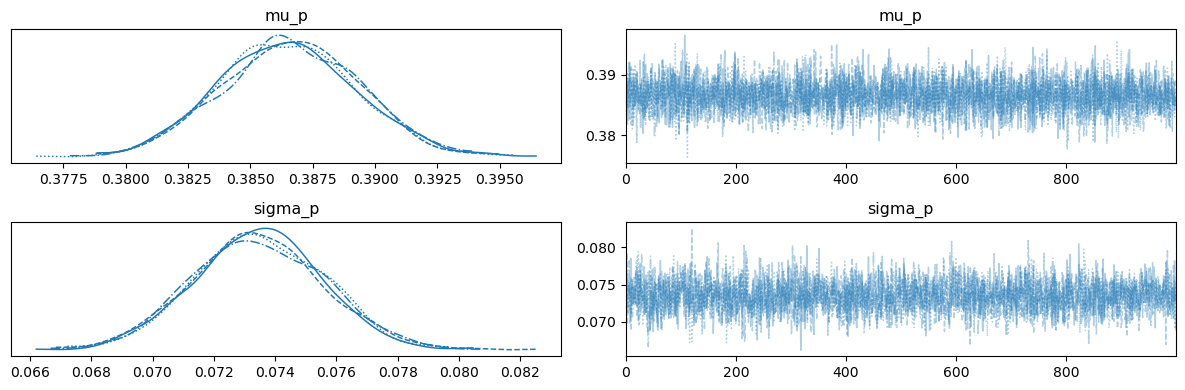

In [39]:
az.plot_trace(trace, var_names=['mu_p', 'sigma_p'])
plt.tight_layout();

array([[<Axes: title={'center': 'peak_age'}>,
        <Axes: title={'center': 'peak_age'}>]], dtype=object)

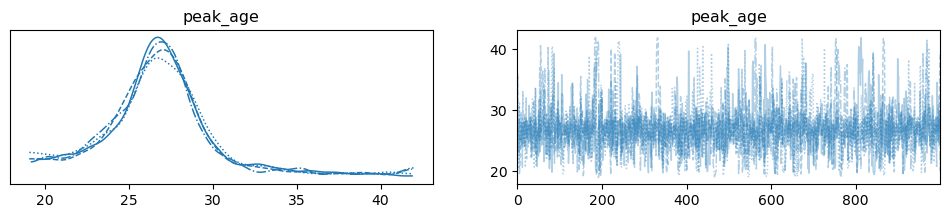

In [40]:
az.plot_trace(trace, var_names='peak_age')

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

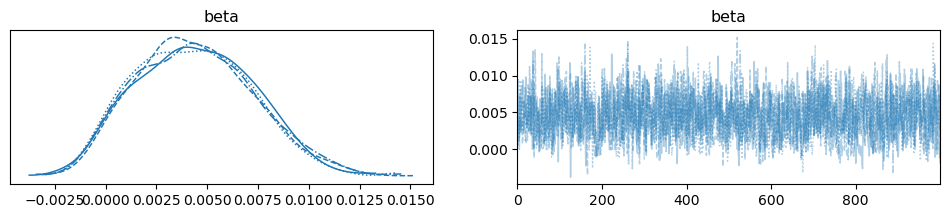

In [41]:
az.plot_trace(trace, var_names='beta')

Sampling: [prediction, rate_like]


Output()

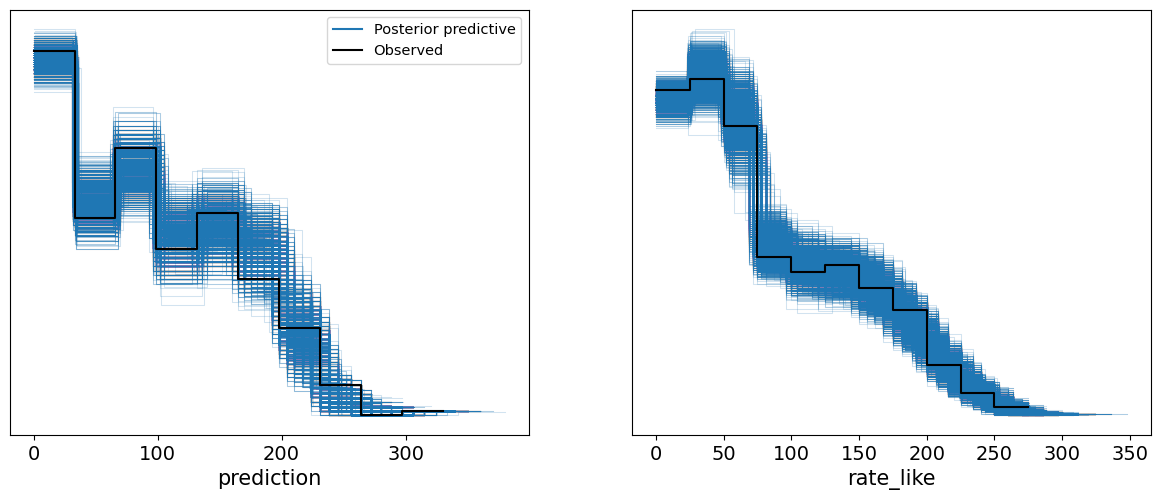

In [76]:
with marcel:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

az.plot_ppc(trace, mean=False);

In [ ]:
pred_seasons = [2021, 2022, 2023]

with marcel:
    pm.set_data(
        {'age_x': hard_hit_by_season["Age"][pred_seasons].to_numpy().astype(np.float32),
         'hard_hit_x': hard_hit_by_season["HardHit"][pred_seasons].to_numpy().astype(np.int32),
         'events_x': hard_hit_by_season["Events"][pred_seasons].to_numpy().astype(np.int32)
        }
    )

    pm.sample_posterior_predictive(trace, var_names=['expected_rate'], predictions=True, extend_inferencedata=True)

In [92]:
p_obs = (hard_hit_by_season.HardHit[2024] / hard_hit_by_season.Events[2024]).to_numpy()

In [115]:
(100 * hard_hit_by_season.Events[2024].fillna(0).values[::-1] / hard_hit_by_season.Events.dropna().to_numpy().max()).astype(int)

array([ 0, 16,  0,  0, 45,  5, 16, 50,  9, 25, 30, 44, 15, 23, 47, 37, 39,
        0, 21, 46,  6, 16, 22, 13, 29, 23,  0, 31,  9,  3,  9, 27, 21, 15,
        0,  1, 26,  0,  0, 13,  0, 28, 41, 39, 39, 33, 44, 19, 10, 27,  0,
        0,  1, 42, 36, 41, 38, 31, 26,  0, 24,  0, 17, 18, 15, 35, 18, 18,
       10,  0, 35, 43,  8, 38, 31,  9, 44,  0, 39,  9, 43, 43, 34, 25, 13,
       43, 20,  0, 30,  0, 43, 26,  0, 23, 14,  0,  7,  0, 24,  0, 19, 24,
        0,  0,  0, 18, 16, 28, 34,  6, 37, 41, 11,  0, 13, 37, 51, 39, 24,
        0, 41,  0,  8,  4, 13, 37, 12, 38, 30, 58, 43, 36, 29, 18, 30, 35,
        0, 11,  0, 16,  9,  0,  0, 20, 26, 17, 45, 33, 31, 34, 43, 42, 32,
       41,  0,  0, 44, 23, 48,  0, 47, 15, 34, 20, 22,  0,  0,  0,  0,  0,
       35,  7,  0,  4,  0, 12,  7, 25, 27,  0, 31,  0, 33, 35, 40,  0, 38,
       25, 16,  5, 15,  0,  0, 26, 46, 18, 16,  0,  0,  2, 25, 31, 26, 16,
       39, 41, 24, 33, 27,  0, 32, 26,  0,  0,  0, 40, 27, 29, 39, 17, 11,
       13, 12, 46,  0,  0

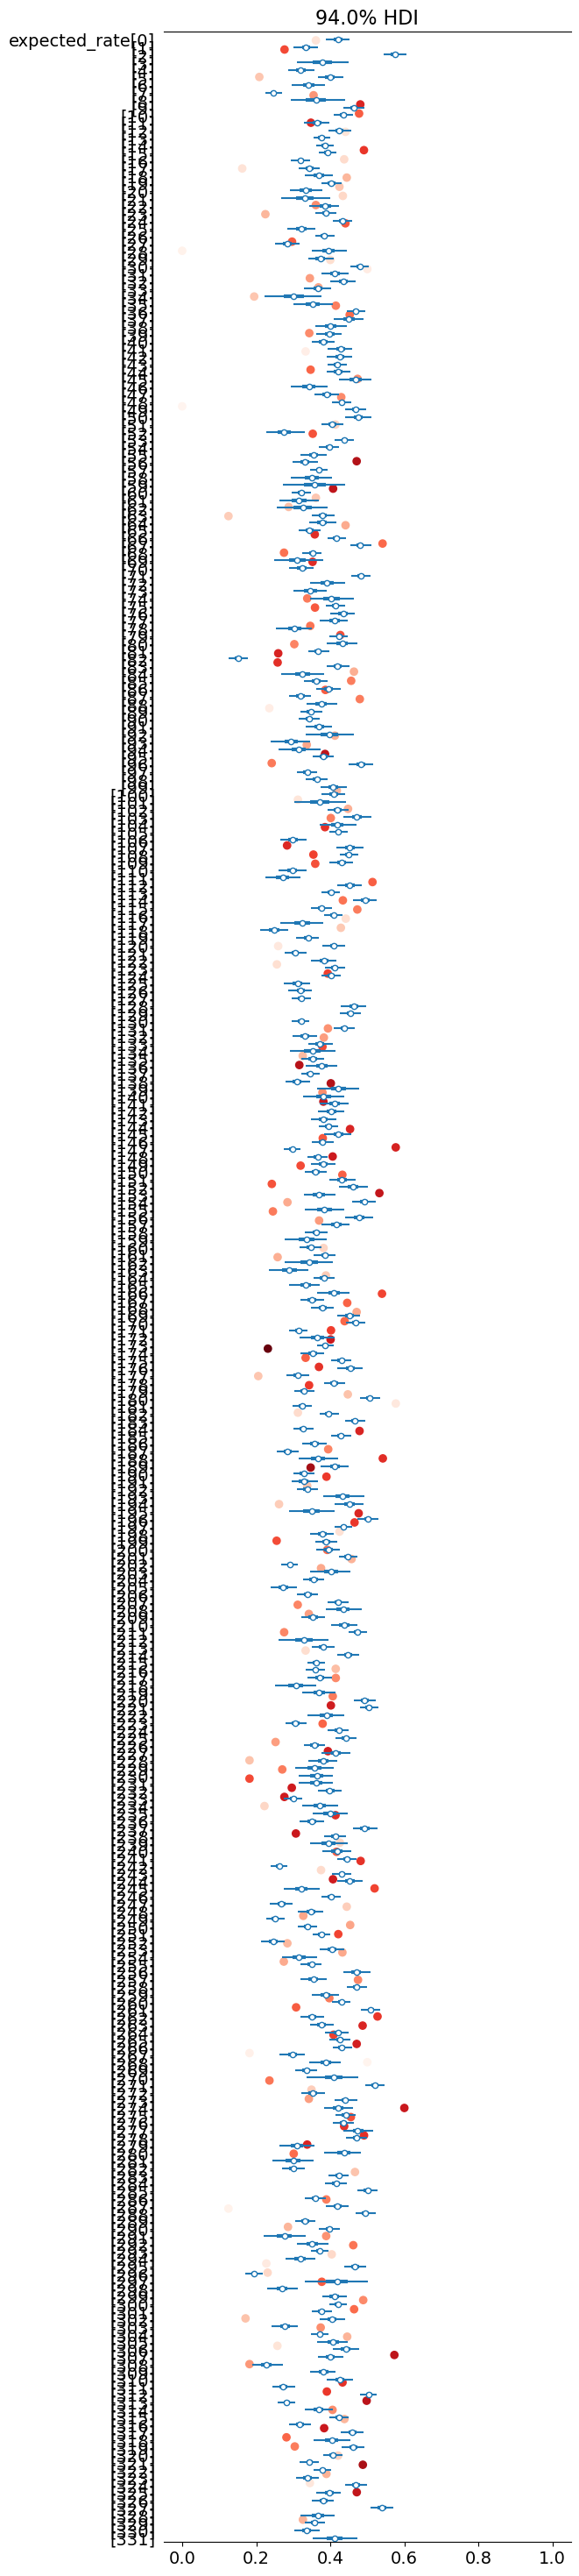

In [122]:
axes = az.plot_forest(trace.predictions['expected_rate'], combined=True)
axes[0].scatter(p_obs[::-1], np.arange(len(p_obs)) + 1, c=list(hard_hit_by_season.Events[2024].fillna(0).values[::-1]), cmap='Reds')   

For this example, I'm just going to use a subset of the whole dataset for fitting and a (much smaller) subset for prediction, as you typically see in traditional machine learning validation exercises. Specifically, I will do a 80:20 split:

In [50]:
year = 2021
predict_subset = get_marcel_data(hard_hit_subset.query("(Season >= @year) & (Season <= @year + 3)"), predict_set=True)

In [55]:
batters[predict_subset[0]].values

array(['Mookie Betts', 'Cody Bellinger', 'Freddie Freeman', 'Jose Altuve',
       'Joey Votto', 'Paul Goldschmidt', 'Manny Machado', 'Nolan Arenado',
       'Trea Turner', 'Fernando Tatis Jr.', 'A.J. Pollock',
       'Buster Posey', 'Brian Dozier', 'J.T. Realmuto', 'Shohei Ohtani',
       'Matt Olson', 'Giancarlo Stanton', 'Robinson Cano', 'Matt Chapman',
       'Brandon Crawford', 'Lorenzo Cain', 'Cedric Mullins II',
       'Gunnar Henderson', 'Bobby Witt Jr.', 'Julio Rodriguez',
       'Nicky Lopez', 'Charlie Blackmon', 'Corbin Carroll', 'Tommy Edman',
       'Miguel Cabrera', 'Matt Carpenter', 'Curtis Granderson',
       'Yoan Moncada', 'Nelson Cruz', 'Yandy Diaz', 'Kyle Tucker',
       'Mitch Haniger', 'Whit Merrifield', 'Edwin Encarnacion',
       'Tim Anderson', 'Byron Buxton', 'Justin Upton', 'Jonathan Lucroy',
       'Andrew Benintendi', 'Ozzie Albies', 'Gary Sanchez',
       'Ender Inciarte', 'Bryson Stott', 'Aaron Hicks', 'Jorge Polanco',
       'T.J. Friedl', 'Michael Brantl

In [69]:
with marcel:

    pm.set_data({
        'hard_hit_x': predict_subset[4].astype(np.int32),
        'events_x': predict_subset[2].astype(np.int32),
        'age_x': predict_subset[1].astype(np.int32),
        'events_y': np.ones(len(predict_subset[3])).astype(np.int32),
        'hard_hit_y': np.ones(len(predict_subset[3])).astype(np.int32),
    }, coords={'batter': batters[predict_subset[0]].values, 'obs': np.arange(len(predict_subset[3]))})

    pm.sample_posterior_predictive(trace, extend_inferencedata=True, predictions=True)


Sampling: [prediction_like, rate_like]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (55, 3) and arg 1 with shape (298, 3).
Apply node that caused the error: binomial_rv{"(),()->()"}(RNG(<Generator(PCG64) at 0x7F1458F34900>), MakeVector{dtype='int64'}.0, events_x, p)
Toposort index: 3
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(int32, shape=(None, None)), TensorType(float64, shape=(None, None))]
Inputs shapes: ['No shapes', (2,), (55, 3), (298, 3)]
Inputs strides: ['No strides', (8,), (12, 4), (24, 8)]
Inputs values: [Generator(PCG64) at 0x7F1458F34900, array([55,  3]), 'not shown', 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [65]:
marcel.p.shape.eval()

array([298,   3])

We are now ready to initialize a model. Again, Motuba uses a scikit-learn-like API, which first involves creating an **instance** of Motuba. This involves providing some information about your model, and getting an initialized `Motuba` object in return that can be used for fitting and projecting.

As a user, you specify 1-3 arguments for the initialization:

- `total_players`: the total number of players to be involved in the analysis, both in the fitting and predicting steps.
- `model_type`: the type of model to be fit (discussed below)
- `peak_age`: the inflection point in age where player performance begins to decline

Only `total_players` is a required argument. If you do not specify a `model_type` then a "normal" model will be assumed and if you do not specify a `peak_age` then age 28 will be used as a default.



In [11]:
fb_stuff_model = Motuba(model_type='normal')

We now have an instantiated `Motuba` object:

In [12]:
fb_stuff_model

The next step is model fitting: this is where we pass the data to the model and let it do its thing. There needs to be four data structures passed to `fit`, including input values and sample sizes (the "X" values and their associated weights) and the target values and their sample sizes (the "y" values and weights).

In [13]:
X_fit = X.loc[fit_pitchers]
y_fit = y.loc[fit_pitchers]

N_x_fit = N_x.loc[fit_pitchers]
N_y_fit = N_y.loc[fit_pitchers]

The other input of interest is the column name of the age variable to be used in fitting a triangular aging curve. The default for this is "age", but you can call it whatever you like as long as you pass it to `fit` as the `age_col` argument. I've included it here just to be explicit.

In [14]:
fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z, sigma, w, beta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 50 seconds.


Fitting them model can take anywhere from seconds to hours, depending on how much data you are using. This example should only take a couple of minutes on a modern machine like an M1 Mac.

What you see above is the output from the underlying PyMC model being fit using Markov chain Monte Carlo (specifically, the NUTS algorithm). You want to keep an eye on this output for any warning messages that may require additional intervention in order to improve the model. This example should run fine under the default conditions.

## Model Checking

Even in the absence of warnings, its always important to check your model. In model checking, we want to know at least two things: did the model fitting algorithm work, and does the model fit the data adequately.

For the first part, we want to do **convergence diagnostics** because we have used a stochastic sampling approach (MCMC) to fit the model. That is, we want some assurance that the sampler *converged* to what the model specifies as the posterior distribution. This implies that the algorithm has had a chance to adequately explore the parameter space of the model. 

The `check_convergence` method will produce an **energy plot** of the fiitted model that gived a visual indication as to whether the model has been able to freely explore the parameter space. You will see two distributions: a marginal energy distribution and an energy transition distribution. Its not important to understand exactly what these are, but you are looking for these two distribtions to mostly overlap, as they should below. When they do not, the difference is usually rather dramatic. The plot below should be close enough.

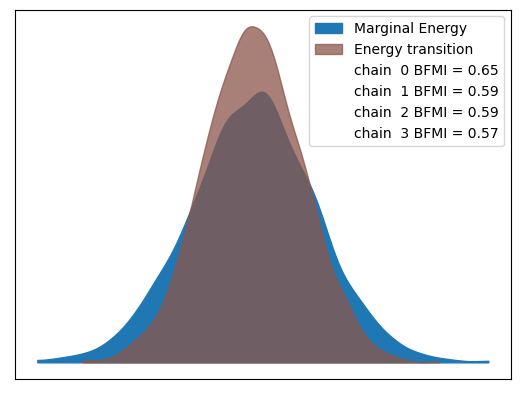

In [15]:
fb_stuff_model.check_convergence();

If we are satisfied that the model has converged, we can move on to the model fit. This is largely the same idea as a model **calibration** check: seeing whether the model predictions correspond adequately to observed values. Since we have a Bayesian model, we can use **posterior predictive checks** for this. This involves simulating several datasets from the model, and comparing the simulated datasets to the actual observed data (in this case, the data used to fit the model). If the model fits, we would expect the observed data to be indistinguishable from some random draw from the model.

The `check_calibration` method automates this for you, generating a visual check whereby a cloud of lines representing a thousand or so simulated datasets are plotted as blue lines alongside the observed data as a thick black line. 

Sampling: [prediction_like, theta_like]


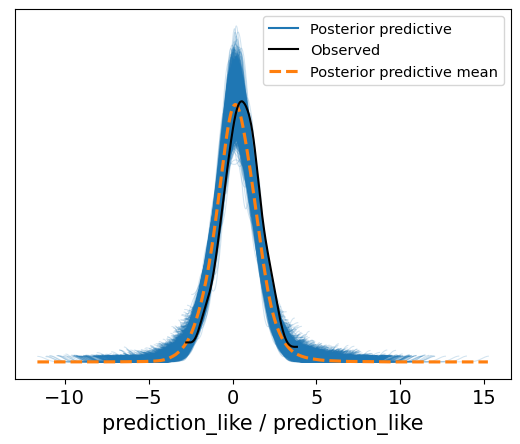

In [16]:
fb_stuff_model.check_calibration();

## Generating Projections

Once we have checked the model and are comfortable with the evaluation, we can use it to generate projections on data it has not yet seen. Again, this will typically be for data leading up to the upcoming season, but here we are just going to use the holdout subset, `pred_pitchers`.

In [17]:
X_pred = X.loc[pred_pitchers]
N_x_pred = N_x.loc[pred_pitchers]
N_y_pred = N_y.loc[pred_pitchers]

The `predict` method has nearly identical arguments to `fit` except we do not have `y` values, since this is what we are trying to forecast. Note that `N_y` is required, though this may be some hypothetical/average value, such as 600 plate appearances or 2000 pitches.

In [18]:
predicted_fb_stuff = fb_stuff_model.predict(X=X_pred, N_x=N_x_pred, N_y=N_y_pred)

Sampling: []


`predict` returns a `DataFrame` of projected values, along with their posterior standard deviation and a 90% prediction interval.

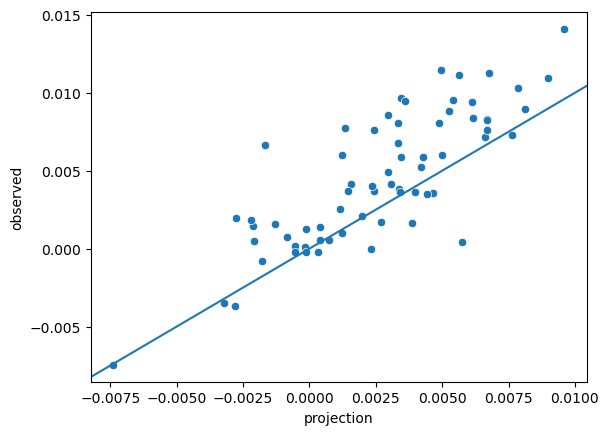

In [19]:
projection = pd.DataFrame(dict(projection=predicted_fb_stuff['mean'].values, observed=y.loc[pred_pitchers].values))
ax = sns.scatterplot(x='projection', y='observed', data=projection)
ax.axline((0, 0), slope=1);

You may be interested in the weights being used by your model to generate the projections. The `get_weights` will return the posterior estimates of the weights, in temporal order from the first year `w[0]` to last `w[2]`. We generally expect the weights to be larger the closer they are to the projection year.

In [20]:
fb_stuff_model.get_weights()

,mean,sd
w[0],0.275,0.042
w[1],0.326,0.053
w[2],0.400,0.040


## Binomial Model

The default normal model is only suitable for continuous-valued quantities that can be reasonably modeled with a normal likelihood, such as stuff, velocity, or WAR. Sometimes we are interested in projecting rates, which involve binomial data, for example, home run rate, K rate, etc. For this, Motuba also had a binomial model.



In [21]:
pred_year = 2021

query_string = f"""
SELECT  
  pa.bam_id,
  pa.season - EXTRACT(YEAR FROM pp.birth_date) age,
  pa.season,
  pa.k_pct,
  pa.k,
  pa.tbf
FROM stats.stats_player_pitching_bylevel pa
JOIN mesa.player pp USING (bam_id)
WHERE pa.game_type = 'R'
    AND pa.source = 'gumbo'
    AND pa.level = 'MLB'
    AND pa.season > {pred_year} - 4
"""

input_data = pandas_gbq.read_gbq(query_string, project_id="phil-new").drop_duplicates(subset=['bam_id', 'season'])

input_grid = (
    input_data[
        input_data.season.isin(np.arange(pred_year - 3, pred_year + 1))
    ]
    .pivot(index="bam_id", columns="season", values=["k", "tbf", "age"])
    .dropna()
)

Downloading: 100%|██████████| 477782/477782 [00:33<00:00, 14065.38rows/s]


In [22]:
X = input_grid['k'].copy()
y = X.pop(pred_year)
N_x = input_grid['tbf'].copy()
N_y = N_x.pop(pred_year)
X["age"] = input_grid[("age", pred_year)]

In [23]:
all_pitchers = X.index.unique().values
fit_pitchers = all_pitchers[:int(len(all_pitchers)*0.8)]
pred_pitchers = all_pitchers[int(len(all_pitchers)*0.8):]

In [24]:
k_pct_model = Motuba(model_type='binomial')

In [25]:
X_fit = X.loc[fit_pitchers].astype(int)
y_fit = y.loc[fit_pitchers].astype(int)

N_x_fit = N_x.loc[fit_pitchers].astype(int)
N_y_fit = N_y.loc[fit_pitchers].astype(int)

In [26]:
k_pct_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, z, w, beta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 85 seconds.


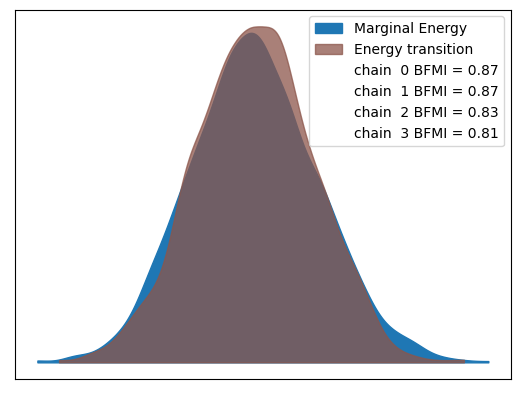

In [27]:
k_pct_model.check_convergence();

In [28]:
k_pct_model.get_weights()

,mean,sd
w[0],0.293,0.025
w[1],0.374,0.027
w[2],0.333,0.024


In [29]:
X_pred = X.loc[pred_pitchers].astype(int)
N_x_pred = N_x.loc[pred_pitchers].astype(int)
N_y_pred = N_y.loc[pred_pitchers].astype(int)

In [30]:
predicted_k_pct = k_pct_model.predict(X=X_pred, N_x=N_x_pred, N_y=N_y_pred)

Sampling: []


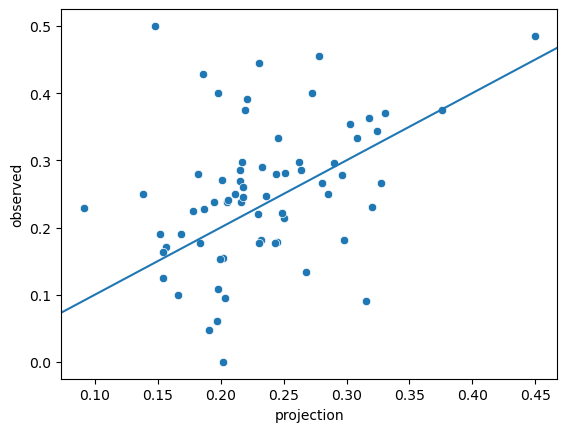

In [31]:
projection = pd.DataFrame(dict(projection=predicted_k_pct['mean'].values, observed=(y/N_y).loc[pred_pitchers].values))
ax = sns.scatterplot(x='projection', y='observed', data=projection)
ax.axline((0.1, 0.1), slope=1)

## When Things Go Wrong

With such a simple model that attempts to project almost anything, inevitably things will go wrong with certain datasets. The first place to look for symptoms of a problem are in the warnings during model fitting. For example, you may read something along the lines of:

> UserWarning: Chain 0 contains 6 diverging samples after tuning. Increase `target_accept` or reparameterize.

This means that the model is (occasionally) having trouble sampling from the model, which results in a **diverging** sample. If this happens only a few times (6 is not many!) things are probably okay, but if there are hundreds or even entirely divergent samples, you will not be able to reliably use inference from the model. 

The underlying PyMC model tries to give advice when it can: while you cannot reparameterize this model, it is possible to change the `target_accept` parameter by passing it to `fit`.  

    fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age", target_accept=0.99)

`target_accept` is the target acceptance rate of the MCMC algorithm, which by default is 0.8. For difficult models, upping this value to 0.9, 0.95 or 0.99 can sometimes solve this issue. Note that higher acceptance rates result in longer runtimes, since it involves taking more steps at every iteration of the model.

If you run into issues with convergence, for example if the energy plots do not look slimiar, the easiest remedy is to run the MCMC model longer--specifically, to add more **tuning steps**. The default number is 3000 tuning steps, but you can change this with the `tune` argument.

    fb_stuff_model.fit(X=X_fit, y=y_fit, N_x=N_x_fit, N_y=N_y_fit, age_col="age", tune=5000)

Of course, there will be some scenarios where Motuba will just not work. If there are issues with the data (e.g. missing values), or the data do not conform to one of the data generating models used in Motuba then you may need to build a bespoke model to account for the particular characteristics of the quantity you are trying to project.


---

## References

- [Tango on Baseball](https://tangotiger.net/marcel/)
- [Baseball-Reference.com](https://www.baseball-reference.com/about/marcels.shtml)


In [73]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jun 27 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.25.0

seaborn   : 0.13.2
matplotlib: 3.8.4
numpy     : 1.26.4
arviz     : 0.18.0
pandas    : 2.2.2
pytensor  : 2.23.0
pymc      : 5.16.1

Watermark: 2.4.3

